# Visualization Report
I've done a lot of work behind the scenes to compile a cool (and undeniably adorable) dataset that we can parse for some interesting results! Today we'll be looking at a combination of the WeRateDogs twitter archive, along with the results of a machine learning algorithm that tried to predict the breed of each dog in the dataset. Along the way, we'll take a look at what some of the features of the best bois, what dog names yield the highest average ratings, and just how far that machine learning algorithm can be led astray. Let's first dive in by importing our data and taking a quick look at it:

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv('twitter_master_archive.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1987 entries, 0 to 1986
Data columns (total 24 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   tweet_id                1987 non-null   int64  
 1   in_reply_to_status_id   23 non-null     float64
 2   in_reply_to_user_id     23 non-null     float64
 3   timestamp               1987 non-null   object 
 4   source                  1987 non-null   object 
 5   text                    1987 non-null   object 
 6   expanded_urls           1987 non-null   object 
 7   rating_numerator        1987 non-null   int64  
 8   rating_denominator      1987 non-null   int64  
 9   name                    1386 non-null   object 
 10  dog_stages              305 non-null    object 
 11  jpg_url                 1987 non-null   object 
 12  img_num                 1987 non-null   int64  
 13  image_prediction1       1987 non-null   object 
 14  prediction1_confidence  1987 non-null   

### Insight 1 / Visualization: Are higher dog ratings associated with more favorites? 
The first thing I asked myself when I saw the dataset was whether WeRateDogs had the same taste in dogs as their fans. This question could be easily answered by looking at their most favorited tweets, and finding the correlation between favorite counts and the dog's rating, as well as visualizing the scatter plot comparing the two with the line of regression identifying that relationship. 


A couple of caveats do exist here though. For one, there are several "themed" ratings that do exist in the dataset, such as an America themed dog rated 1776, and a picture of Snoop Dogg tagged 420. For that reason, I'll do a touch more wrangling to eliminate a few outliers, and calculate our predictions.

In [36]:
df.rating_numerator.value_counts()

12      448
10      418
11      396
13      257
9       151
8        95
7        52
14       35
5        33
6        32
3        19
4        16
2         9
1         5
0         2
420       1
24        1
1776      1
27        1
44        1
45        1
50        1
60        1
75        1
80        1
84        1
88        1
99        1
121       1
143       1
144       1
165       1
204       1
26        1
Name: rating_numerator, dtype: int64

In [37]:
# Identify values in our ratings to filter as outliers;
filtered = df[df.groupby('rating_numerator').rating_numerator.transform('count') > 1]
filtered.rating_numerator.value_counts()

12    448
10    418
11    396
13    257
9     151
8      95
7      52
14     35
5      33
6      32
3      19
4      16
2       9
1       5
0       2
Name: rating_numerator, dtype: int64

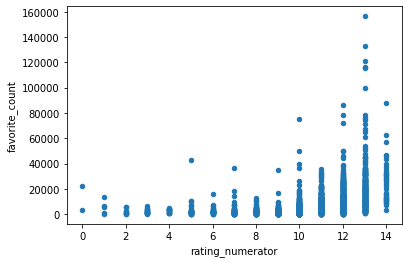

In [39]:
filtered.plot.scatter(x='rating_numerator', y='favorite_count');

Well, as we might expect, the rating is definitely positively associated with favorite count. But what's the average favorite count for each rating? This might provide us with more insight into the relationship between the two.

In [44]:
filtered.groupby('rating_numerator')['favorite_count'].describe()

,count,mean,std,min,25%,50%,75%,max
rating_numerator,,,,,,,,
0,2.0,12707.500000,13867.071086,2902.0,7804.75,12707.5,17610.25,22513.0
1,5.0,5254.000000,5426.334813,138.0,801.00,5545.0,6108.00,13678.0
2,9.0,2043.333333,2040.358302,380.0,555.00,1128.0,2838.00,5430.0
3,19.0,2170.578947,1618.819196,468.0,982.00,1828.0,3014.00,6455.0
4,16.0,2595.312500,1455.358042,521.0,1074.50,3101.5,3568.50,4866.0
5,33.0,3617.606061,7525.433023,96.0,787.00,1760.0,2387.00,43026.0
6,32.0,2471.875000,2987.475175,103.0,925.75,1471.0,2648.50,16150.0
7,52.0,3405.538462,5865.304447,100.0,722.25,1546.0,3360.75,36769.0
8,95.0,2231.031579,2284.699540,105.0,723.50,1544.0,3126.00,12541.0


So as we can see from above, the relationship isn't perfectly linear, with some dogs having a higher favorite count despite a lower rating than others (e.g. dogs rated 5 recieve 3617 favorites, versus dogs rated 6 who recieve on average 2471). While some of this is a result of the frequency at which WeRateDogs hands out these ratings, it's still interesting nonetheless. 


### Insight 2: What are the highest rated dog names on average?
There are a ton of dogs in our dataset, but there are several who share the same name. Let's see if we can identify which of these names is rated the highest on average:

In [68]:
# Pare down our dataset to just those dogs with repeated names
filtered_names = filtered[filtered.groupby('name').rating_numerator.transform('count') > 1]

# Group the dogs by name and calculate an average rating for each name
filtered_names.groupby('name')['rating_numerator'].mean().sort_values(ascending=False)

name
Paisley    13.000000
Kevin      13.000000
Peaches    13.000000
Zeke       12.666667
Boomer     12.666667
             ...    
an          6.833333
Crystal     6.500000
Bernie      6.500000
Hammond     5.500000
Patrick     5.000000
Name: rating_numerator, Length: 225, dtype: float64

Seems like we've got a three way tie at the top, with Paisley, Kevin, and Peaches all in a dead heat at 13. And who can pick a favorite? I can't. They're all good dogs. 

### Insight 3: What are the most predicted things that are *not dogs*?

Frequently, machine learning applications have a tendency to classify particular kinds of dogs incorrectly, like this classic image showing the difficult task at hand, which humans can identify but computers cannot. 

![Poor pups](imgs/img1.jpeg)

But as hilarious as these results can often be, I was curious about what else the prediction algorithm might have to say when it's not properly classifying dogs, and then ponder about the reasons this might be, and if they're as straightforward as our muffin pups above.

In [84]:
# Let's take a look at just the prediction data that got it wrong
wrong = filtered_names[(filtered_names['is_prediction1_dog']==False)|
                       (filtered_names['is_prediction2_dog']==False)|
                       (filtered_names['is_prediction3_dog']==False)]

# We're going to have to grab the series of unique predictions some other way
p1 = filtered_names[filtered_names['is_prediction1_dog']==False]['image_prediction1'].values
p2 = filtered_names[filtered_names['is_prediction2_dog']==False]['image_prediction2'].values
p3 = filtered_names[filtered_names['is_prediction3_dog']==False]['image_prediction3'].values

# Let's... assemble one long list of long predictions as a Dataframe and then run value_counts()
wrongs = pd.DataFrame(np.concatenate([p1, p2, p3]), columns=['wrong_ids'])
wrongs['wrong_ids'].value_counts()

seat_belt     16
teddy         13
doormat       12
ice_bear       8
dingo          8
              ..
stone_wall     1
jaguar         1
hay            1
hair_spray     1
coffee_mug     1
Name: wrong_ids, Length: 264, dtype: int64

Well. Of all the things I thought I'd see on here, seat belts were not at the top of my list. Let's take a look at two of these and see why seat belt might have been the case:

In [83]:
filtered_names[filtered_names['image_prediction1']=='seat_belt']['jpg_url']

269     https://pbs.twimg.com/media/C4BiOXOXAAAf6IS.jpg
497     https://pbs.twimg.com/media/Cu0hlfwWYAEdnXO.jpg
573     https://pbs.twimg.com/media/Crsgi9dWEAApQd8.jpg
624     https://pbs.twimg.com/media/CpcWknPXYAAeLP9.jpg
760     https://pbs.twimg.com/media/CllNnkWWMAEDIAR.jpg
1790    https://pbs.twimg.com/media/CUr9NjgU8AEpf5w.jpg
Name: jpg_url, dtype: object

![pupperoni](imgs/img2.jpg)
![pupperuski](imgs/img3.jpg)

Sure enough, dogs in cars. That makes sense. The algorithm sees a car, it's not sure what it's predicting in the first place, so, sure, seatbelt might be a reasonable assumption. Same goes for teddy bears. I know pups are definitely as cuddly as teddy bears, that's for sure. Let's just check up on those doormats, just out of sheer curiosity.

In [85]:
filtered_names[filtered_names['image_prediction1']=='doormat']['jpg_url']

848     https://pbs.twimg.com/media/CiD3AfkXEAA3S_r.jpg
1821    https://pbs.twimg.com/media/CUi3PIrWoAAPvPT.jpg
Name: jpg_url, dtype: object

![doorpup](imgs/img4.jpg)

And indeed, where there is small pup, and a lot of floor, our algorithm might not know exactly where to focus, and as such, returns a sad prediction of doormat. Well, in my world, no pup is a doormat. They are all special indeed. 

# Conclusion
While there's still a lot more that can be parsed from this dataset, hopefully this goes to show that with a few quick commands, all data has a story to tell, some more cute and entertaining than others!